 # Step 4: Train Final Classifier



 Train a binary classifier on the balanced dataset:



 1. Data: Split 80/20 (stratified), encode with all-mpnet-base-v2

 2. Model: Dense(32) → Dropout(0.5) → Dense(8) → Dropout(0.5) → Dense(1)

 3. Training: Two-phase approach

    - Phase 1: Find best epochs with early stopping

    - Phase 2: Retrain on full training set

 4. Evaluation: Test accuracy, misclassification analysis by source



 The final model is saved to './models/final_classifier.h5'.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import keras
from keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


/opt/anaconda3/envs/text_class/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the balanced training dataset
train_df = pd.read_csv('balanced_training_dataset.csv')


In [3]:
# Split into train and test sets (80/20)
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])


In [4]:
# Load the sentence transformer model
ST_model = SentenceTransformer('all-mpnet-base-v2')  # all-MiniLM-L6-v2 (for faster training)


In [5]:
# Generate embeddings for the cleaned_text
print('Generating embeddings for training data...')
batch_size = 32
train_embeddings = []
for i in tqdm(range(0, len(train_df), batch_size)):
    batch = train_df['cleaned_text'].iloc[i:i+batch_size].tolist()
    batch_embed = ST_model.encode(batch)
    train_embeddings.extend(batch_embed)
train_embeddings = np.array(train_embeddings)

print('Generating embeddings for test data...')
test_embeddings = []
for i in tqdm(range(0, len(test_df), batch_size)):
    batch = test_df['cleaned_text'].iloc[i:i+batch_size].tolist()
    batch_embed = ST_model.encode(batch)
    test_embeddings.extend(batch_embed)
test_embeddings = np.array(test_embeddings)


Generating embeddings for training data...


100%|██████████| 376/376 [00:26<00:00, 14.13it/s]


Generating embeddings for test data...


100%|██████████| 94/94 [00:05<00:00, 17.30it/s]


In [6]:
# Prepare labels (binary: sarcastic=1, literal=0)
train_labels = (train_df['label'] == 'sarcastic').astype(int).values
test_labels = (test_df['label'] == 'sarcastic').astype(int).values


In [7]:
# Build the Keras model
model = models.Sequential([
    layers.Input(shape=(train_embeddings.shape[1],)),  # Use Input layer for the shape
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary (number of parameters per layer)
print("\nModel summary (number of parameters per layer):")
model.summary()



Model summary (number of parameters per layer):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,881 (97.19 KB)

 Trainable params: 24,881 (97.19 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train with early stopping to find best epoch
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
print('Training with early stopping to find best epoch...')
history = model.fit(
    train_embeddings, train_labels,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Training with early stopping to find best epoch...
Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.6738 - loss: 0.6193 - val_accuracy: 0.8068 - val_loss: 0.4464
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.8030 - loss: 0.4825 - val_accuracy: 0.8201 - val_loss: 0.4246
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.8189 - loss: 0.4513 - val_accuracy: 0.8235 - val_loss: 0.4112
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.8224 - loss: 0.4463 - val_accuracy: 0.8226 - val_loss: 0.4032
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.8273 - loss: 0.4361 - val_accuracy: 0.8201 - val_loss: 0.4060
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.8291 - loss: 0.4347 - val_accuracy: 0.8226 - val_loss: 0.3995
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.8382 - loss: 0.4097 - val_accuracy: 0.8185 - val_loss: 0.3970
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━

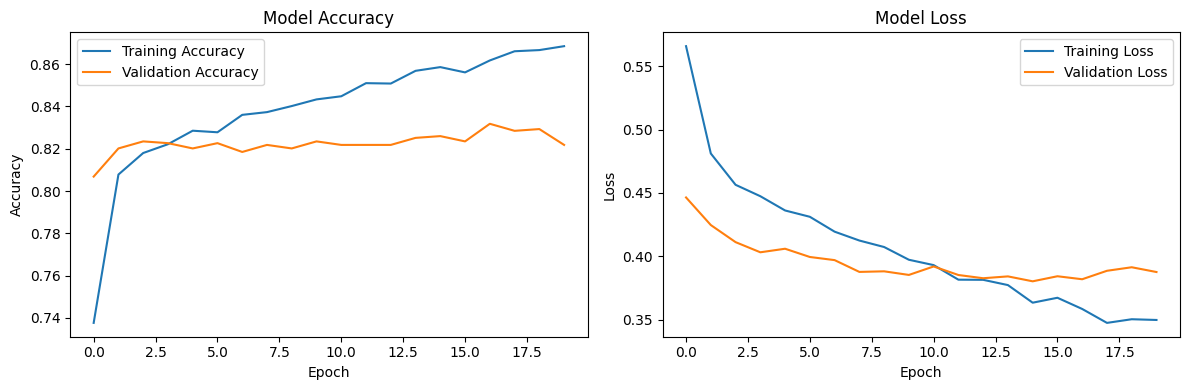

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# Find the best epoch
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f'Best number of epochs found: {best_epoch}')


Best number of epochs found: 15


In [11]:
# Retrain on the full training set for the best number of epochs
final_model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(train_embeddings.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
final_model.compile(
    optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(f'Retraining on full training set for {best_epoch} epochs...')
final_model.fit(
    train_embeddings, train_labels,
    epochs=best_epoch,
    batch_size=32,
    verbose=1
)


Retraining on full training set for 15 epochs...
Epoch 1/15


/opt/anaconda3/envs/text_class/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.6921 - loss: 0.6000
Epoch 2/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.8035 - loss: 0.4907
Epoch 3/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.8112 - loss: 0.4675
Epoch 4/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.8254 - loss: 0.4477
Epoch 5/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.8200 - loss: 0.4456
Epoch 6/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.8275 - loss: 0.4333
Epoch 7/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.8393 - loss: 0.4170
Epoch 8/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.8398 - loss: 0.4096
Epoch 9/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.8445 - loss: 0.4054
Epoch 10/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.8425 - loss: 0.4017
Epoch 11/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.8459 - loss: 0.3989
Epoch 12/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
# Evaluate on the test set
print('Evaluating on the test set...')
test_loss, test_acc = final_model.evaluate(test_embeddings, test_labels, verbose=1)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


Evaluating on the test set...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.8480 - loss: 0.3708 
Test accuracy: 0.8447, Test loss: 0.3748


In [13]:
# Save the final model
final_model.save('final_classifier.h5')
print('Final classifier model saved to final_classifier.h5')


Final classifier model saved to final_classifier.h5


In [14]:
# Print some examples where the model is making mistakes on the test set

# Get model predictions (probabilities and binary)
test_pred_probs = final_model.predict(test_embeddings)
test_pred_labels = (test_pred_probs.flatten() > 0.5).astype(int)

# Find misclassified indices
misclassified = np.where(test_pred_labels != test_labels)[0]

print(f"\nNumber of misclassified examples in test set: {len(misclassified)}\n")
print("Some misclassified examples (original, true label, predicted label, probability):\n")

# Map label int to string
label_map = {1: "sarcastic", 0: "literal"}

for idx in misclassified[:10]:  # Show up to 10 examples
    orig = test_df.iloc[idx]['text']
    true_label = label_map[test_labels[idx]]
    pred_label = label_map[test_pred_labels[idx]]
    prob = test_pred_probs[idx][0]
    print(f"Text: {orig}\nTrue label: {true_label}\nPredicted: {pred_label} (prob={prob:.2f})\n{'-'*60}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step

Number of misclassified examples in test set: 466

Some misclassified examples (original, true label, predicted label, probability):

Text: @MichBell I know, I'm sobbing about how long it's been right now. 
True label: sarcastic
Predicted: literal (prob=0.44)
------------------------------------------------------------
Text: @josey4628 hahaha i was just there like 2 days ago, freaking hilarious 
True label: sarcastic
Predicted: literal (prob=0.48)
------------------------------------------------------------
Text: @threnn put it off for ages, but finally caved... when i dropped &amp; killed my iphone last week. boo &amp; yay! hehe 
True label: sarcastic
Predicted: literal (prob=0.43)
------------------------------------------------------------
Text: @mileycyrus haha my twin sisters love your show..not gna lie i saw it once or twice  lol, you got a sick voice
True label: literal
Predicted: sarcastic (prob=0.74)
-----------------------------------

In [15]:
# Summarize the source of incorrect classifications
misclassified_sources = test_df.iloc[misclassified]['source']
source_counts = misclassified_sources.value_counts()

# Also print percentage of misclassified examples per source
# Count total examples per source in the test set
total_per_source = test_df['source'].value_counts()

print("\nSummary of sources for misclassified test examples (with percentage):")
for source, count in source_counts.items():
    total = total_per_source.get(source, 0)
    percent = (count / total * 100) if total > 0 else 0
    print(f"{source}: {count} misclassified out of {total} ({percent:.1f}%)")



Summary of sources for misclassified test examples (with percentage):
real-literal-FP: 151 misclassified out of 218 (69.3%)
real-sarcastic-FN: 123 misclassified out of 133 (92.5%)
synthetic-literal: 69 misclassified out of 449 (15.4%)
real-sarcastic-TP: 64 misclassified out of 754 (8.5%)
synthetic-sarcastic: 48 misclassified out of 567 (8.5%)
real-literal-TN: 11 misclassified out of 880 (1.2%)
